# Transaction data clustering 


Clustering is a data mining technique that entails grouping similar types of data or queries together in order to facilitate the identification of related subject areas. It can be used to segment markets, employees, footballers or products and is a powerful way to discover hidden relationships in data. There are several well-known clustering algorithms that everyone is familiar with, including K-means, DBSCAN, and hierarchical clustering. However, the primary issue with transactional data, which includes market basket data, financial orders, point-of-sale transaction records, and web logs, is that they frequently contain large collections of categorical data of varying sizes. In this context, the majority of traditional approaches to segmenting discrete valued data into meaningful and representative clusters may become unsuitable and difficult.


To ensure reproducibility, I'll be utilising Instacart Orders as the primary dataset. I'll do my best in this notebook to compare and evaluate various algorithms for clustering categorical data (if possible?). The primary goal of this project is to efficiently group large database of transaction records and to find interesting and meaningful buying habits of the customers. 

Cool, cool, cool... 

Right, the main algorithms that I'll be looking at are: 

- K modes 
- K prototype
- RObust Clustering using LinKs 
- CLOPE
- COOLCAT 
- Product2vec (Word2vec derivatives) 
- Latent Dirichlet Allocation
- Graph mining & Community detection


Visit https://www.kaggle.com/c/instacart-market-basket-analysis for more information. 



# Instacart data & Data Preperation

In [1]:
#Import libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
#load data
directory = "/Users/jasonsmacbook/Documents/GitHub/Transaction-data-clustering/instacart-market-basket-analysis/"
orders = pd.read_csv(directory + 'orders.csv' )
products = pd.read_csv(directory + 'products.csv')
order_products_prior = pd.read_csv(directory + 'order_products__prior.csv')
aisles = pd.read_csv(directory + 'aisles.csv')

In [16]:
merged_order = order_products_prior.merge(orders)[["order_id","user_id","product_id"]]

In [30]:
#Repeated order -> i.e. order that contains multiple 
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


/Users/jasonsmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of users')

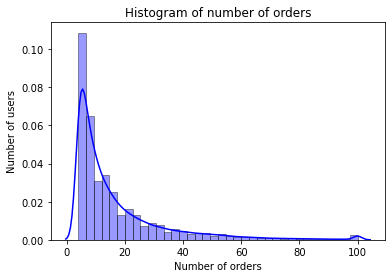

In [33]:
#number of orders by each user 
order_count = orders.groupby(["user_id"]).order_id.nunique()
# seaborn histogram
sns.distplot(order_count.to_list(), hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of number of orders')
plt.xlabel('Number of orders')
plt.ylabel('Number of users')



/Users/jasonsmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of orders')

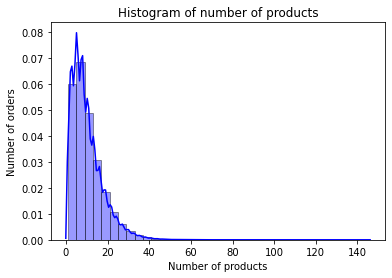

In [34]:
#number of products in each order 
product_count = order_products_prior.groupby(["order_id"]).product_id.nunique()
# seaborn histogram
sns.distplot(product_count.to_list(), hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of number of products')
plt.xlabel('Number of products')
plt.ylabel('Number of orders')


In [35]:
#Flatten order data into transaction records 
#i.e. order_id, basket:{product_id:1,product_id:2}
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


# RObust Clustering using LinKs

The first 